In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [5]:
input_path = '/Users/ytu/data/biddings.csv'

In [6]:
data = pd.read_csv(input_path)
print(data.shape)

(1000000, 89)


### Explore input data

Only ~0.2% of rows have `convert = true`

In [8]:
pd.value_counts(data['convert'])[1]/data.shape[0] * 100

0.1908

#### Sample the same number of rows where `convert = false` and  `convert = true`

In [83]:
def down_sampling(minority_ratio=1, majority_to_minority=1):
    convert1_sample = data.loc[data['convert'] == 1] * minority_ratio
    convert0_sample = data.loc[data['convert'] == 0].sample(majority_to_minority * len(convert1_sample))

    # shuffle
    sample = pd.concat([convert0_sample, convert1_sample]).sample(frac=1)
    
    features = sample.drop('convert', axis=1)
    labels = sample.convert

    print("features: {}, lables = {}".format(features.shape, labels.shape))
        
    return (np.array(features), np.array(labels))


(features, labels) = down_sampling()

features: (3816, 88), lables = (3816,)


#### Logistic Regression

In [94]:
from sklearn.linear_model import LogisticRegression

Cross validation with mean accuracy as test metric

In [95]:
from sklearn.model_selection import KFold
from sklearn.metrics import auc, roc_curve

# Returns mean accuracies and aucs
def train_kfold(n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True)
    
    accuracies = np.array([])
    ftrs = np.array([])
    tprs = np.array([])
    
    for train_index, test_index in kf.split(features):
    #     print("TRAIN:", train_index, "TEST:", test_index)
        feature_train, feature_test = features[train_index], features[test_index]
        label_train, label_test = labels[train_index], labels[test_index]

        regression = LogisticRegression(penalty='l2')
        model = regression.fit(feature_train, label_train)
        predicted_scores = model.predict_proba(feature_test)[:,1]
        
        accuracies = np.append(accuracies, model.score(feature_test, label_test))
        ftr, tpr, thresholds = roc_curve(label_test, predicted_scores)
        ftrs = np.append(ftrs, ftr)
        tprs = np.append(tprs, tpr)
    
    return accuracies, ftrs, tprs

We use ROC_AUC (Receiver operating characteristic area under curve) as the main metric rather than accuracy because the label distribution is highly unbalanced. But since we are using under-sampled data here, we should look at accuracy as well.

First try different number of folds, and see if there is any difference in AUC

In [80]:
for i, n_splits in enumerate(range(2, 6)):
    accuracies, ftrs, tprs = train_kfold(n_splits)
    area_under_cruve = auc(ftrs, tprs, True)
    print("splits: {}, accuracy: {}, auc: {}".format(n_splits, np.mean(accuracies), area_under_cruve))


splits: 2, accuracy: 0.624475890985325, auc: 0.6753896142936907
splits: 3, accuracy: 0.6181865828092243, auc: 0.6697788386153622
splits: 4, accuracy: 0.625, auc: 0.6734510678303969
splits: 5, accuracy: 0.6263087289769647, auc: 0.6790714786805572


There is very little difference with number of folds. This makes sense because we are under-sampling,
and taining data is small even if splits = 2. Go ahead with 2 splits and plot the ROC curve, where AUC is around 67.5%

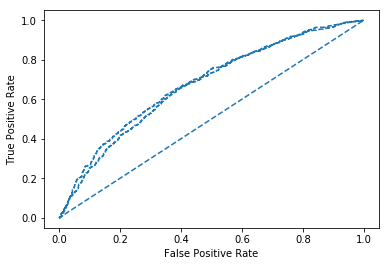

In [82]:
accuracies, ftrs, tprs = train_kfold(2)
plt.plot(ftrs, tprs, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
    

However, we don't have to down sample at a 1:1 ratio of labels (convert = 0 vs. convert = 1).
Try increasing the ratio to increase the sample size expotentially.
Accuracy improves up to 99% as the 0/1 ratio approaches the true distribution, whic AUC is stagnent.
This is due to most of the accuracy gains in fewer false positives


In [93]:
for majority_to_minority in [4, 8, 16, 32, 64, 128]:
    (features, labels) = down_sampling(majority_to_minority=majority_to_minority)
    accuracies, fprs, tprs = train_kfold(2)
    area_under_cruve = auc(fprs, tprs, True)
    print("0:1 ratio: {}, accuracy: {}, fpr: {}, tpr: {}, auc: {}".format(
        majority_to_minority, np.mean(accuracies), np.mean(fprs), np.mean(tprs), area_under_cruve))

features: (9540, 88), lables = (9540,)
0:1 ratio: 4, accuracy: 0.8015723270440251, fpr: 0.38719636706291105, tpr: 0.5780020971001182, auc: 0.6857856580919355
features: (17172, 88), lables = (17172,)
0:1 ratio: 8, accuracy: 0.888248311204286, fpr: 0.3991685516122108, tpr: 0.5910334422597876, auc: 0.6914232429846777
features: (32436, 88), lables = (32436,)
0:1 ratio: 16, accuracy: 0.9410223208780368, fpr: 0.444084997773489, tpr: 0.6300485798975402, auc: 0.6883979219667756
features: (62964, 88), lables = (62964,)
0:1 ratio: 32, accuracy: 0.9696810876056159, fpr: 0.5030386088980643, tpr: 0.6872414962277547, auc: 0.691435374623664
features: (124020, 88), lables = (124020,)
0:1 ratio: 64, accuracy: 0.984558942106112, fpr: 0.5467918656018328, tpr: 0.7305854747395728, auc: 0.6911756581095445
features: (246132, 88), lables = (246132,)
0:1 ratio: 128, accuracy: 0.9922236848520306, fpr: 0.5765305283380178, tpr: 0.7552978330754501, auc: 0.685268416969126


In [119]:
# Without KFold
from sklearn.model_selection import train_test_split
def train(features, labels, test_size=0.33, penalty='l2'):
    feature_train, feature_test, label_train, label_test = train_test_split(features, labels, test_size=test_size)
    
    regression = LogisticRegression(penalty=penalty)
    model = regression.fit(feature_train, label_train)
    predicted_scores = model.predict_proba(feature_test)[:,1]
    predicted = model.predict(feature_test)
    accuracy = model.score(feature_test, label_test)
    fpr, tpr, thresholds = roc_curve(label_test, predicted_scores)
    return accuracy, fpr, tpr, label_test, predicted


features: (9540, 88), lables = (9540,)
majority_to_minority: 4, accuracy: 0.803, fpr: 0.365, tpr: 0.571, auc: 0.697
0.28869805443662866
[[2486   41]
 [ 579   43]]
features: (32436, 88), lables = (32436,)
majority_to_minority: 16, accuracy: 0.939, fpr: 0.450, tpr: 0.631, auc: 0.687
0.28869805443662866
[[10051     3]
 [  649     1]]
features: (124020, 88), lables = (124020,)
majority_to_minority: 64, accuracy: 0.985, fpr: 0.551, tpr: 0.729, auc: 0.690
0.28869805443662866
[[40328     0]
 [  599     0]]


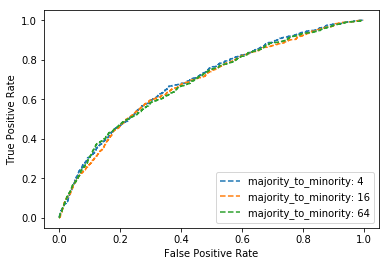

In [117]:
# 4, 16, 64
from sklearn.metrics import confusion_matrix

for majority_to_minority in [4, 16, 64]:
    (features, labels) = down_sampling(majority_to_minority=majority_to_minority)
    accuracy, fpr, tpr, label_test, predicted = train(features, labels)
    area_under_curve = auc(fpr, tpr)
    print("majority_to_minority: %d, accuracy: %0.3f, fpr: %0.3f, tpr: %0.3f, auc: %0.3f" % (
        majority_to_minority, accuracy, np.mean(fpr), np.mean(tpr), area_under_curve))
    print(predicted_scores[0])
    
    # true negatives is C_{0,0}, false negatives is C_{1,0},
    # true positives is C_{1,1} and false positives is C_{0,1}.
    print(confusion_matrix(label_test, predicted))
    
    plt.plot(fpr, tpr, label="majority_to_minority: %d" % majority_to_minority, linestyle='--')
    plt.legend(loc='lower right')

    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


Try L1 penalty
No meaningful improvement on AUC: + False negative, - True negative

features: (9540, 88), lables = (9540,)
accuracy: 0.799, fpr: 0.376, tpr: 0.565, auc: 0.683
0.28869805443662866
[[2455   71]
 [ 562   61]]


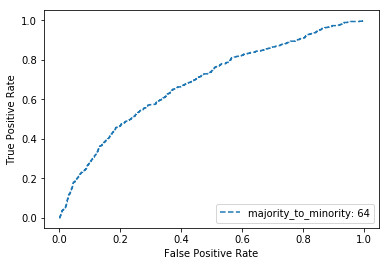

In [121]:
(features, labels) = down_sampling(majority_to_minority=4)
accuracy, fpr, tpr, label_test, predicted = train(features, labels, penalty='l1')
area_under_curve = auc(fpr, tpr)
print("accuracy: %0.3f, fpr: %0.3f, tpr: %0.3f, auc: %0.3f" % (
    accuracy, np.mean(fpr), np.mean(tpr), area_under_curve))
print(predicted_scores[0])

# true negatives is C_{0,0}, false negatives is C_{1,0},
# true positives is C_{1,1} and false positives is C_{0,1}.
print(confusion_matrix(label_test, predicted))

plt.plot(fpr, tpr, label="majority_to_minority: %d" % majority_to_minority, linestyle='--')
plt.legend(loc='lower right')

    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()